# CHAPTER 6 게이트가 추가된 RNN

5장에서 본 RNN은 순환 경로를 포함하여 과거의 정보를 기억할 수 있으며 구조가 단순하여 구현도 쉽게 가능하지만 성능이 좋지 못하였는데 그 원인은 시계열 데이터에서 시간적으로 멀리 떨어진, 즉 **장기 의존 관계를 잘 학습할 수 없기 때문**

### 6.1 RNN의 문제점

RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어려움. BPTT에서 **기울기 소실 혹은 기울기 폭발**이 때문

![1](https://media.vlpt.us/post-images/dscwinterstudy/1159e620-4b07-11ea-a7ae-e999224db48a/fig-6-4.png)

RNNLM의 관점에서 보면 정답 레이블이 'Tom'임을 학습할 때 중요한 것이 바로 RNN 계층의 존재<br>
RNN 계층이 과거 방향으로 '의미 있는 기울기'를 전달함으로 시간 방향의 의존 관계를 학습할 수 있음

여기서 기울기는 학습해야 할 의미가 있는 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습<br>
하지만 중간에 기울기가 사그라들면 가중치 매개변수는 전혀 갱신되지 않게 되어 장기 의존 관계를 학습할 수 없게 됨<br>
현재는 RNN 계층에서 시간을 거슬러 올라가 기울기가 작아지거나 커져 소실 혹은 폭발되는 상황

#### 기울기 소실과 기울기 폭발의 원인

![2](https://media.vlpt.us/post-images/dscwinterstudy/979eea50-4b07-11ea-a39d-699a549f4f48/fig-6-5.png)

위의 RNN 계층의 그림에서 시간 방향 기울기 전파에만 주목함.
길이가 T인 시계열 데이터를 가정, T번째 정답 레이블로부터 전해지는 기울기의 변화?
- 앞의 문제에 대입하면 T번째 정답 레이블이 'Tom'인 경우에 해당
- 이때 시간 방향 기울기에 주목하면 역전파로 전해지는 기울기는 차례로 'tanh','+','MatMul(행렬 곱)' 연산을 통과

'+'의 역전파는 상류에서 전해지는 기울기를 그대로 하류로 흘러보내 기울기는 변하지 않음

'tanh'의 경우와 미분된 경우의 그래프
![3](https://media.vlpt.us/post-images/dscwinterstudy/3aab0710-4b08-11ea-a39d-699a549f4f48/fig-6-6.png)

점선이 y=tanh(x)의 미분이고 값은 1.0 이하이며, x가 0으로부터 멀어질수록 작아짐<br>
역전파에서 기울기가 tanh 노드를 지날 때마다 값은 계속 작아짐. tanh 함수를 T번 통과하면 기울기도 T번 반복해서 작아짐.

'MatMul(행렬 곱)' 노드의 경우 tanh 노드를 무시-> 그러면 RNN 계층의 역전파 시 기울기는 아래 그림과 같이 'MatMul' 연산에 의해서만 변화

![4](https://media.vlpt.us/post-images/dscwinterstudy/98f8df90-4b08-11ea-bee9-c16c025c7fb9/fig-6-7.png)

 행렬 곱의 기울기는 시간에 비례해 지수적으로 증가/감소함

- 증가할 경우? **기울기 폭발**
기울기 폭발이 일어나면 오버플로를 일으켜 NaN 같은 값을 발생시킴

- 감소할 경우? **기울기 소실**
일정 수준 이하로 작아지면 가중치 매개변수가 더 이상 갱신되지 않으므로 장기 의존 관계를 학습할 수 없게 됨

#### 기울기 폭발 대책

**기울기 클리핑**

![5](https://blog.kakaocdn.net/dn/uiIIw/btqCjQAh2xa/seoggvNOcOCLooXWNOIQZ0/img.png)

기울기의 L2노름이 문턱값을 초과하면 두 번째 줄의 수식과 같이 기울기를 수정

In [1]:
# 기울기 클리핑 구현

import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())


before: [5.57658499 1.04908355 8.00622884 6.81465691 4.74151504 1.88437192
 8.15692658 9.31937732 0.68789136]
after: [1.04226449 0.19607386 1.49636525 1.27366029 0.8861898  0.35218937
 1.52453068 1.74179288 0.12856699]


### 6.2 기울기 소실과 LSTM

![6](https://media.vlpt.us/images/dscwinterstudy/post/211ad6bf-24f1-4132-9f84-a5d414f753c8/fig%206-11.png)

LSTM계층의 인터페이스엔 **C**라는 경로가 있음

c: 기억셀이라고 하며, LSTM 전용 기억 메커니즘

#### LSTM 계층 조립하기

![7](https://media.vlpt.us/images/dscwinterstudy/post/46398c57-b304-434b-aebb-2ca665da6a1a/fig%206-12.png)

그림에서 현재의 기억 셀 c_t는 3개의 입력 (c(t-1),h_(t-1),x_t)으로부터 '어떤 계산'을 수행하여 구할 수 있음<br>
핵심? 갱신된 c_t를 사용해 은닉 상태 h_t를 계산한다는 것<br>
또한 이 계산은 h_t=tanh(c_t)인데, 이는 c_t의 각 요소에 tanh 함수를 적용한다는 뜻

 문을 열거나 닫을 수 있듯이, 게이트는 데이터의 흐름을 제어한다.

![8](https://media.vlpt.us/images/dscwinterstudy/post/253159b7-0240-41e7-a944-24090e7876bf/fig%206-14.png)

게이트의 열림 사애는 그림에서처럼 0.0~1.0 사이의 실수로 나타나며 1.0은 완전한 개방을 의미함<br>
그 값이 다음으로 흐르는 물의 양을 결정

- 여기서 중요한 것은 '게이트를 얼마나 열까'라는 것도 데이터로부터 자동으로 학습한다는 점이다.

#### output 게이트

output 게이트의 열림 상태는 입력 xt와 이전 상태 h(t-1)로부터 구함

![9](https://media.vlpt.us/images/dscwinterstudy/post/494a88a1-9718-408c-abb5-95199d97126c/fig%206-15.png)

#### forget 게이트

기억 셀에 '무엇을 잊을까'를 명확하게 지시

![10](https://media.vlpt.us/images/dscwinterstudy/post/f03b9010-3343-4ee3-87b7-d7b06dfe955b/fig%206-16.png)

#### 새로운 기억 셀

forget 게이트를 거치면서 이전 시각의 기억 셀로부터 잊어야 할 기억이 삭제됨

![11](https://media.vlpt.us/images/dscwinterstudy/post/db1a12f0-084e-41ee-8f99-5107002ead3e/fig%206-17.png)

#### input 게이트

input 게이트는 g의 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단<br>
새 정보를 무비판적으로 수용하는 게 아니라, 적절히 취사선택하는 것이 이 게이트의 역할<br>
input 게이트에 의해 가중된 정보가 새로 추가되는 셈

![12](https://media.vlpt.us/images/dscwinterstudy/post/7f655948-5f3d-4a7f-b2df-7f37d534570a/fig%206-18.png)

#### LSTM의 기울기 흐름

![13](https://media.vlpt.us/images/dscwinterstudy/post/24d75848-2a19-4403-a78d-7a558042c8d0/fig%206-19.png)

In [2]:
# 구현

class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

#### Time LSTM 구현

Time LSTM은 T개분의 시계열 데이터를 한꺼번에 처리하는 계층

![14](https://media.vlpt.us/images/dscwinterstudy/post/44954a14-f9b5-4224-9a8a-cc6cb26e8265/fig%206-25.png)

Truncated BPTT는 역전파의 연결은 적당한 길이로 끊으며, 순전파의 흐름은 그래도 유지


In [3]:
#구현

class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

### LSTM을 사용한 언어 모델

앞장에서 구현한 언어모델과의 차이는 LSTM을 사용한다는 것 뿐임

In [4]:
import sys
sys.path.append("C:/Users/minjuKim/Desktop/[FIN_AI]_study_myself/deep-learning-from-scratch-2-master")
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.25
| 에폭 1 |  반복 21 / 1327 | 시간 8[s] | 퍼플렉서티 2665.65
| 에폭 1 |  반복 41 / 1327 | 시간 17[s] | 퍼플렉서티 1241.45
| 에폭 1 |  반복 61 / 1327 | 시간 26[s] | 퍼플렉서티 972.71
| 에폭 1 |  반복 81 / 1327 | 시간 34[s] | 퍼플렉서티 795.81
| 에폭 1 |  반복 101 / 1327 | 시간 43[s] | 퍼플렉서티 651.71
| 에폭 1 |  반복 121 / 1327 | 시간 52[s] | 퍼플렉서티 651.76
| 에폭 1 |  반복 141 / 1327 | 시간 60[s] | 퍼플렉서티 588.22
| 에폭 1 |  반복 161 / 1327 | 시간 69[s] | 퍼플렉서티 587.36
| 에폭 1 |  반복 181 / 1327 | 시간 77[s] | 퍼플렉서티 569.51
| 에폭 1 |  반복 201 / 1327 | 시간 86[s] | 퍼플렉서티 502.83
| 에폭 1 |  반복 221 / 1327 | 시간 95[s] | 퍼플렉서티 483.23
| 에폭 1 |  반복 241 / 1327 | 시간 104[s] | 퍼플렉서티 447.63
| 에폭 1 |  반복 261 / 1327 | 시간 114[s] | 퍼플렉서티 467.36
| 에폭 1 |  반복 281 / 1327 | 시간 123[s] | 퍼플렉서티 444.66
| 에폭 1 |  반복 301 / 1327 | 시간 132[s] | 퍼플렉서티 383.40
| 에폭 1 |  반복 321 / 1327 | 시간 140[s] | 퍼플렉서티 339.12
| 에폭 1 |  반복 341 / 1327 | 시간 150[s] | 퍼플렉서티 404.52
| 에폭 1 |  반복 361 / 1327 | 시간 159[s] | 퍼플렉서티 401.52
| 에폭 1 |  반복 381 / 1327 | 시간 168[s] | 퍼플렉서

| 에폭 3 |  반복 501 / 1327 | 시간 1339[s] | 퍼플렉서티 130.65
| 에폭 3 |  반복 521 / 1327 | 시간 1347[s] | 퍼플렉서티 139.74
| 에폭 3 |  반복 541 / 1327 | 시간 1355[s] | 퍼플렉서티 137.20
| 에폭 3 |  반복 561 / 1327 | 시간 1362[s] | 퍼플렉서티 119.30
| 에폭 3 |  반복 581 / 1327 | 시간 1370[s] | 퍼플렉서티 107.11
| 에폭 3 |  반복 601 / 1327 | 시간 1378[s] | 퍼플렉서티 150.22
| 에폭 3 |  반복 621 / 1327 | 시간 1386[s] | 퍼플렉서티 144.38
| 에폭 3 |  반복 641 / 1327 | 시간 1394[s] | 퍼플렉서티 131.33
| 에폭 3 |  반복 661 / 1327 | 시간 1402[s] | 퍼플렉서티 121.02
| 에폭 3 |  반복 681 / 1327 | 시간 1409[s] | 퍼플렉서티 101.73
| 에폭 3 |  반복 701 / 1327 | 시간 1417[s] | 퍼플렉서티 120.43
| 에폭 3 |  반복 721 / 1327 | 시간 1425[s] | 퍼플렉서티 126.32
| 에폭 3 |  반복 741 / 1327 | 시간 1433[s] | 퍼플렉서티 108.41
| 에폭 3 |  반복 761 / 1327 | 시간 1441[s] | 퍼플렉서티 105.18
| 에폭 3 |  반복 781 / 1327 | 시간 1449[s] | 퍼플렉서티 106.30
| 에폭 3 |  반복 801 / 1327 | 시간 1457[s] | 퍼플렉서티 116.34
| 에폭 3 |  반복 821 / 1327 | 시간 1464[s] | 퍼플렉서티 117.63
| 에폭 3 |  반복 841 / 1327 | 시간 1472[s] | 퍼플렉서티 113.95
| 에폭 3 |  반복 861 / 1327 | 시간 1480[s] | 퍼플렉서티 120.36
| 에폭 3 |  반복

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from c

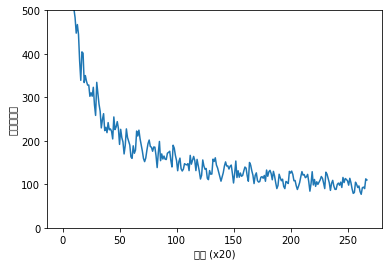

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  136.70701618791762


In [5]:
# PTB학습

from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

### 6.5 RNNLM 추가 개선

#### LSTM 계층 다중화

![15](https://media.vlpt.us/images/dscwinterstudy/post/962a9cbd-ec80-4365-b7d9-10045598ea32/fig%206-29.png)

RNNLM으로 정확한 모델을 만들고자 한다면 많은 경우 LSTM 계층을 깊게 쌓아 효과를 볼 수 있음<br>
지금까지는 1층만 사용했지만 2층, 3층 식으로 여러 겹 쌓으면 언어 모델의 정확도가 향상되리라 기대

#### 드롭아웃에 의한 과적합 억제

RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킴

드롭아웃? 흔련 시 계층 내의 뉴런 몇개를 무작위로 무시하고 학습

![16](https://media.vlpt.us/images/dscwinterstudy/post/34d46f9e-d783-444f-b6cb-beadc86727ae/fig%206-33.png)

시간방향(좌우)으로 아무리 진행해도 정보를 잃지 않고, 깊이방향(상하)에만 영향

![17](https://media.vlpt.us/images/dscwinterstudy/post/dd7f0519-684e-4910-835d-7c44c51c824b/fig%206-34.png)

같은 계층의 드롭 아웃끼리 마스크를 공유함으로써 마스크가 고정됨.<br>
정보를 잃게되는 방법도 고정되므로 일반적인 드롭아웃때와 달리 정보가 지수적으로 손실되는 사태를 피할 수 있음

#### 가중치 공유

언어 모델을 개선하는 간단한 트릭

![18](https://media.vlpt.us/images/dscwinterstudy/post/e3705441-5a2a-4a50-b6d9-591ef8c00aeb/fig%206-35.png)

In [6]:
#개선된 RNN 구현
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


Train-> 오래걸림^^

#### 정리
- 단순한 RNN의 학습에서는 기울기 소실과 기울기 폭발이 문제가 된다
- 기울기 폭발에는 기울기 클리핑, 기울기 소실에는 게이트가 추가된 RNN(LSTM, GRU 등)이 효과적이다
- LSTM에는 input 게이트, forget 게이트, output 게이트 등 3개의 게이트가 있어
- 게이트에는 전용 가중치가 있으며, 시그모이드 함수를 사용하여 0-1사이의 실수를 출력한다.
- 언어 모델 개선에는 LSTM 계층 다중화, 드롭아웃, 가중치 공유등의 기법이 효과적이다.
- RNN의 정규화는 중요한 주제이며, 드롭아웃 기반의 다양한 기법이 제안되고 있다.